# Creating A YOLO Object Detection Model



In [3]:
gpu_num = "cuda:0,1"

In [4]:
# Setup Scripts
from ultralytics import YOLO
from roboflow import Roboflow
from IPython.display import display
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
import os
import supervision as sv
import papermill
import pickle

print("setup complete")
x = 1
print(x)

## Set working directory
print(os.getcwd())


setup complete
1
/gpfs/gibbs/project/miranda/fwb7/yolov8


In [5]:
print(x)

1


Everything's working now, so we'll move on to getting the model set up.

In [6]:
cwd = os.getcwd()
beta = "beta3"
model_name = "v3_data_yolo11x2"
model_loc = os.path.join(cwd, beta, model_name)
model_weight = os.path.join(model_loc, "weights/best.pt")

In [7]:
model = YOLO(model_weight)

So we've now uploaded our model that we trained using SBATCH. Let's inspect the weights.

In [8]:
model.info

<bound method Model.info of YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(384, eps=0.001, moment

# Beta 3: Our 3rd Attempt!

**Dataset: v3_data**

**Model Name: `v3_data_yolo11x2`**

Classes: ['moving-car', 'moving-heavy-truck', 'moving-light-truck', 'stationary-car-offstreet', 'stationary-car-onstreet', 'stationary-heavy-truck-offstreet', 'stationary-heavy-truck-onstreet', 'stationary-light-truck-offstreet', 'stationary-light-truck-onstreet']

In [9]:
data_dir = "/vast/palmer/scratch/miranda/fwb7/yolov8/v3/data.yaml"
v3_classes = ['moving-car', 'moving-heavy-truck', 'moving-light-truck', 'stationary-car-offstreet', 'stationary-car-onstreet', 'stationary-heavy-truck-offstreet', 'stationary-heavy-truck-onstreet', 'stationary-light-truck-offstreet', 'stationary-light-truck-onstreet']
# Print as list
df = pd.DataFrame(v3_classes, columns =["Class Name"])
display(df)

,Class Name
0,moving-car
1,moving-heavy-truck
2,moving-light-truck
3,stationary-car-offstreet
4,stationary-car-onstreet
5,stationary-heavy-truck-offstreet
6,stationary-heavy-truck-onstreet
7,stationary-light-truck-offstreet
8,stationary-light-truck-onstreet


While we are using hyperparameter optimization to finetune the results of the first run, let's validate the model and have a look at the results.



## View Original Results:

In [10]:
df = pd.read_csv("beta3/v3_data_yolo11x2/results.csv")
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.17980,2.21330,1.09880,0.30412,0.18994,0.15203,0.09369,1.28220,1.8414,1.1766,0.000235,0.000235,0.000235
1,2,1.30580,1.63590,1.18850,0.32714,0.17737,0.09662,0.05629,1.53310,4.0875,1.4481,0.000471,0.000471,0.000471
2,3,1.47570,1.78060,1.28020,0.16839,0.16353,0.06011,0.03051,1.77750,4.3833,1.5967,0.000706,0.000706,0.000706
3,4,1.48660,1.82830,1.28600,0.10228,0.17459,0.08521,0.04560,1.45890,2.9498,1.3872,0.000708,0.000708,0.000708
4,5,1.43100,1.69990,1.26840,0.10227,0.22609,0.05865,0.02995,1.52460,inf,1.4302,0.000706,0.000706,0.000706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,222,0.66114,0.50215,0.89930,0.59277,0.42487,0.42896,0.28348,0.98795,0.93072,1.0543,0.000359,0.000359,0.000359
222,223,0.66140,0.46033,0.90674,0.56682,0.41109,0.41640,0.27933,1.00340,0.93036,1.0597,0.000357,0.000357,0.000357
223,224,0.67326,0.46278,0.87185,0.40526,0.43331,0.39592,0.26030,1.01020,0.96113,1.0620,0.000356,0.000356,0.000356
224,225,0.66367,0.45621,0.92322,0.60932,0.40150,0.43016,0.28485,1.00580,0.94393,1.0627,0.000354,0.000354,0.000354


As we see, the model trained for 226 epochs on the first run. Let's produce some graphs of the different metrics over time.


## Graph of mAP 50 against Epochs

In [11]:
# Inspect column names and head of the DataFrame
print(df.columns)  # Display all column names
print(df.head())   # Preview the first few rows



Index(['                  epoch', '         train/box_loss',
       '         train/cls_loss', '         train/dfl_loss',
       '   metrics/precision(B)', '      metrics/recall(B)',
       '       metrics/mAP50(B)', '    metrics/mAP50-95(B)',
       '           val/box_loss', '           val/cls_loss',
       '           val/dfl_loss', '                 lr/pg0',
       '                 lr/pg1', '                 lr/pg2'],
      dtype='object')
                  epoch        train/box_loss        train/cls_loss  \
0                     1                1.1798                2.2133   
1                     2                1.3058                1.6359   
2                     3                1.4757                1.7806   
3                     4                1.4866                1.8283   
4                     5                1.4310                1.6999   

         train/dfl_loss  metrics/precision(B)     metrics/recall(B)  \
0                1.0988               0.30412       

In [12]:
# Clean up column names
df.columns = df.columns.str.strip()

# Check cleaned column names
print(df.columns)

epochs = df['epoch']
precision = df['metrics/precision(B)']
recall = df['metrics/recall(B)']
mAP50 = df['metrics/mAP50(B)']
mAP5095 = df['metrics/mAP50-95(B)']

Index(['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


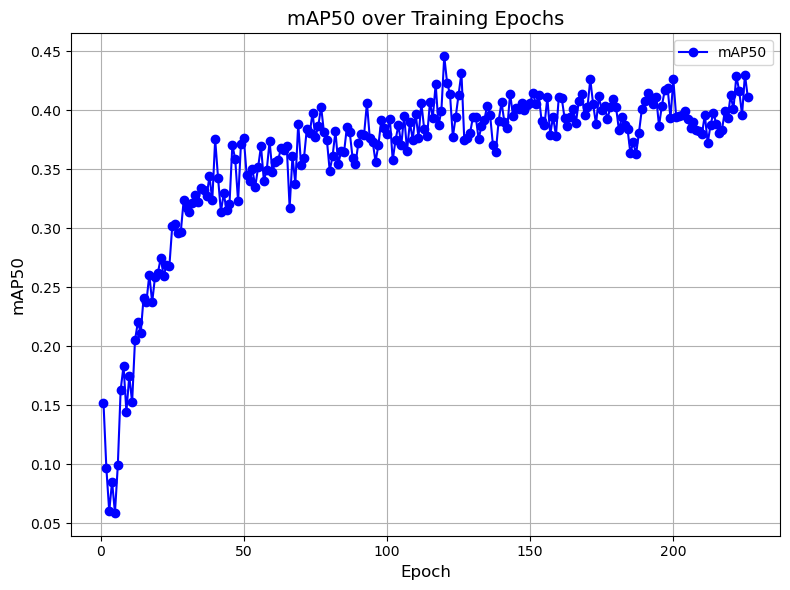

In [13]:
# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, mAP50, marker='o', linestyle='-', color='b', label='mAP50')

# Add labels, title, and legend
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('mAP50', fontsize=12)
plt.title('mAP50 over Training Epochs', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

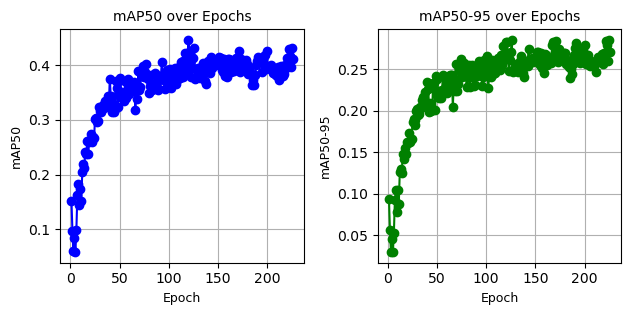

In [14]:
# Set up the figure for two side-by-side square graphs
fig, axes = plt.subplots(1, 2, figsize=(6.5, 3.25))  # Total width = 6.5, height = 3.25

# Plot mAP50
axes[0].plot(epochs, mAP50, marker='o', linestyle='-', color='b')
axes[0].set_title('mAP50 over Epochs', fontsize=10)
axes[0].set_xlabel('Epoch', fontsize=9)
axes[0].set_ylabel('mAP50', fontsize=9)
axes[0].grid(True)

# Plot mAP50-95
mAP50_95 = df['metrics/mAP50-95(B)']  # Assuming this column exists
axes[1].plot(epochs, mAP50_95, marker='o', linestyle='-', color='g')
axes[1].set_title('mAP50-95 over Epochs', fontsize=10)
axes[1].set_xlabel('Epoch', fontsize=9)
axes[1].set_ylabel('mAP50-95', fontsize=9)
axes[1].grid(True)

# Adjust layout to ensure the plots fit nicely within the space
plt.tight_layout()

# Save the figure to a file and display it
plt.savefig('figs/v3_yolo11x_mAP50_mAP5095.jpg', dpi=300, format='jpeg')  # Save as JPEG
plt.show()

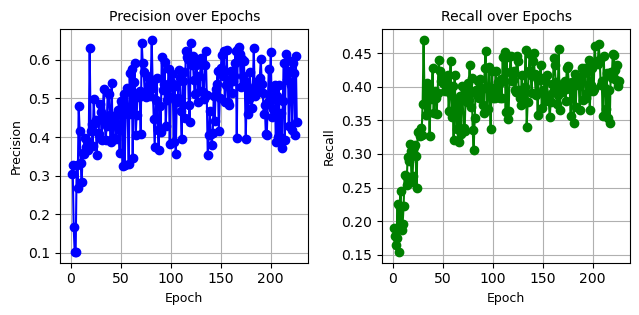

In [15]:
# Set up the figure for two side-by-side square graphs
fig, axes = plt.subplots(1, 2, figsize=(6.5, 3.25))  # Total width = 6.5, height = 3.25

# Plot Precision
axes[0].plot(epochs, precision, marker='o', linestyle='-', color='b')
axes[0].set_title('Precision over Epochs', fontsize=10)
axes[0].set_xlabel('Epoch', fontsize=9)
axes[0].set_ylabel('Precision', fontsize=9)
axes[0].grid(True)

# Plot Recall
axes[1].plot(epochs, recall, marker='o', linestyle='-', color='g')
axes[1].set_title('Recall over Epochs', fontsize=10)
axes[1].set_xlabel('Epoch', fontsize=9)
axes[1].set_ylabel('Recall', fontsize=9)
axes[1].grid(True)

# Adjust layout
plt.tight_layout()

# Save the figure as a JPEG
plt.savefig('figs/v3_yolo11x_recall_precision.jpg', dpi=300, format='jpeg')  # Save as JPEG
plt.show()

## Validate on Validation Set

Let's validate this data!

In [16]:
print(data_dir)
print(model_loc)
model.names.items()
display(pd.DataFrame(list(model.names.items()), columns=['Class ID', 'Class Name']))


/vast/palmer/scratch/miranda/fwb7/yolov8/v3/data.yaml
/gpfs/gibbs/project/miranda/fwb7/yolov8/beta3/v3_data_yolo11x2


,Class ID,Class Name
0,0,moving-car
1,1,moving-heavy-truck
2,2,moving-light-truck
3,3,stationary-car-offstreet
4,4,stationary-car-onstreet
5,5,stationary-heavy-truck-offstreet
6,6,stationary-heavy-truck-onstreet
7,7,stationary-light-truck-offstreet
8,8,stationary-light-truck-onstreet


In [1]:

# Setup Scripts
from ultralytics import YOLO
from roboflow import Roboflow
from IPython.display import display
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
import os
import supervision as sv
import papermill
import pickle


In [ ]:

# ## MODEL 1
# data_b1_dir = "/gpfs/gibbs/project/miranda/fwb7/yolov8/v2/data.yaml"
# model_b1_dir = "/gpfs/gibbs/project/miranda/fwb7/yolov8/beta1/yolo11x_test1/weights/best.pt"
# model_b1 = YOLO(model_b1_dir)

# results_b1 = model_b1.val(data=data_b1_dir,
#                           name="val_b1_1",
#                           project="/gpfs/gibbs/project/miranda/fwb7/yolov8/beta1",
#                           device=[0, 1, 2, 3],
#                           batch=16,
#                           verbose=True,
#                           plots=True,
#                           save_json=True)

# # Save the results object to a file
# with open('/gpfs/gibbs/project/miranda/fwb7/yolov8/val_results/results_b1.pkl', 'wb') as f:
#     pickle.dump(results_b1, f)
# print("Results object saved as 'val_results/results_b1.pkl'")
 

In [2]:


## MODEL 2
data_b2_dir = "/gpfs/gibbs/project/miranda/fwb7/yolov8/v2/data.yaml"
model_b2_dir = "/gpfs/gibbs/project/miranda/fwb7/yolov8/beta2/v2_data_yolo11x/weights/best.pt"
model_b2 = YOLO(model_b2_dir)

results_b2 = model_b2.val(data=data_b2_dir,
                          name="val_b2_1",
                          project="/gpfs/gibbs/project/miranda/fwb7/yolov8/beta2",
                          device=[0, 1],
                          batch=16,
                          verbose=True,
                          plots=True,
                          save_json=True)

# # Save the results object to a file
# with open('/gpfs/gibbs/project/miranda/fwb7/yolov8/val_results/results_b2.pkl', 'wb') as f:
#     pickle.dump(results_b2, f)

# print("Results object saved as 'val_results/results_b2.pkl'")


Ultralytics 8.3.7 🚀 Python-3.10.13 torch-2.4.1 CUDA:0 (Tesla V100-SXM2-32GB, 32494MiB)
                                                CUDA:1 (Tesla V100-SXM2-32GB, 32494MiB)
YOLO11x summary (fused): 464 layers, 56,847,814 parameters, 0 gradients


val: Scanning /gpfs/gibbs/project/miranda/fwb7/yolov8/v2/valid/labels.cache... 297 images, 36 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.92it/s]


                   all        297       1207      0.635       0.32      0.353       0.22
        moving-bicycle          8          9      0.607      0.333      0.409      0.162
            moving-bus          8         11      0.733      0.502      0.565      0.467
            moving-car         81        158      0.598      0.411       0.47      0.304
    moving-heavy-truck         15         15      0.598        0.3      0.378      0.245
    moving-light-truck         32         46       0.46      0.304      0.303      0.199
     moving-motorcycle          3          3          0          0     0.0628     0.0321
stationary-bicycle-onstreet          5          5      0.506        0.6      0.578      0.241
stationary-car-offstreet         64        157      0.669       0.42      0.523      0.313
stationary-car-onstreet        185        688       0.82      0.736      0.832      0.597
stationary-heavy-truck-offstreet          1          1          1          0          0          0
sta

In [3]:

## MODEL 3
data_b3_dir = "/vast/palmer/scratch/miranda/fwb7/yolov8/v3/data.yaml"
model_b3_dir = "/gpfs/gibbs/project/miranda/fwb7/yolov8/beta3/v3_data_yolo11x/weights/best.pt"
model_b3 = YOLO(model_b3_dir)

results_b3 = model_b3.val(data=data_b3_dir,
                          name="val_b3_1",
                          project="/gpfs/gibbs/project/miranda/fwb7/yolov8/beta3",
                          device=[0, 1],
                          batch=16,
                          verbose=True,
                          plots=True,
                          save_json=True)

# # Save the results object to a file
# with open('/gpfs/gibbs/project/miranda/fwb7/yolov8/val_results/results_b3.pkl', 'wb') as f:
#     pickle.dump(results_b3, f)

# print("Results object saved as 'val_results/results_b3.pkl'")


Ultralytics 8.3.7 🚀 Python-3.10.13 torch-2.4.1 CUDA:0 (Tesla V100-SXM2-32GB, 32494MiB)
                                                CUDA:1 (Tesla V100-SXM2-32GB, 32494MiB)
YOLO11x summary (fused): 464 layers, 56,837,419 parameters, 0 gradients


val: Scanning /vast/palmer/scratch/miranda/fwb7/yolov8/v3/valid/labels.cache... 297 images, 39 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.75it/s]


                   all        297       1168      0.594      0.396      0.432      0.286
            moving-car         81        158      0.552      0.443      0.445      0.278
    moving-heavy-truck         21         26      0.914       0.41      0.608      0.426
    moving-light-truck         32         46      0.402      0.391      0.409      0.274
stationary-car-offstreet         64        157      0.648      0.469      0.532      0.307
stationary-car-onstreet        185        688      0.743      0.805      0.815      0.579
stationary-heavy-truck-offstreet          1          1          1          0      0.249      0.127
stationary-heavy-truck-onstreet          6          8       0.43      0.375      0.305      0.218
stationary-light-truck-offstreet         13         13      0.119     0.0769     0.0607     0.0419
stationary-light-truck-onstreet         55         71      0.538      0.592      0.467      0.323
Speed: 0.4ms preprocess, 11.0ms inference, 0.0ms loss, 0.9ms postproc

Conf = 0.01
Ultralytics 8.3.7 🚀 Python-3.10.13 torch-2.4.1 CUDA:0 (Tesla V100-SXM2-32GB, 32494MiB)
                                                CUDA:1 (Tesla V100-SXM2-32GB, 32494MiB)
YOLO11x summary (fused): 464 layers, 56,837,419 parameters, 0 gradients
val: Scanning /vast/palmer/scratch/miranda/fwb7/yolov8/v3/valid/labels.cache... 297 images, 39 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<?, ?it/s]
UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.75it/s]
                   all        297       1168      0.594      0.396      0.432      0.286
            moving-car         81        158      0.552      0.443      0.445      0.278
    moving-heavy-truck         21         26      0.914       0.41      0.608      0.426
    moving-light-truck         32         46      0.402      0.391      0.409      0.274
stationary-car-offstreet         64        157      0.648      0.469      0.532      0.307
stationary-car-onstreet        185        688      0.743      0.805      0.815      0.579
stationary-heavy-truck-offstreet          1          1          1          0      0.249      0.127
stationary-heavy-truck-onstreet          6          8       0.43      0.375      0.305      0.218
stationary-light-truck-offstreet         13         13      0.119     0.0769     0.0607     0.0419
stationary-light-truck-onstreet         55         71      0.538      0.592      0.467      0.323
Speed: 0.4ms preprocess, 11.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Saving /gpfs/gibbs/project/miranda/fwb7/yolov8/beta3/val_b3_14/predictions.json...
Results saved to /gpfs/gibbs/project/miranda/fwb7/yolov8/beta3/val_b3_14

Conf = 0.25
                Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.85it/s]
                   all        297       1168      0.483      0.396      0.431      0.316
            moving-car         81        158      0.552      0.443      0.479      0.341
    moving-heavy-truck         21         26      0.914       0.41      0.681      0.528
    moving-light-truck         32         46      0.402      0.391      0.437       0.31
stationary-car-offstreet         64        157      0.648      0.469      0.567      0.369
stationary-car-onstreet        185        688      0.743      0.805      0.804      0.613
stationary-heavy-truck-offstreet          1          1          0          0          0          0
stationary-heavy-truck-onstreet          6          8       0.43      0.375      0.355      0.264
stationary-light-truck-offstreet         13         13      0.119     0.0769     0.0765     0.0535
stationary-light-truck-onstreet         55         71      0.538      0.592      0.479      0.368

Conf = 0.5


In [4]:

## MODEL 4
data_b4_dir = "/vast/palmer/scratch/miranda/fwb7/yolov8/v4/data.yaml"
model_b4_dir = "/gpfs/gibbs/project/miranda/fwb7/yolov8/beta4/v4_yolo11x/weights/best.pt"
model_b4 = YOLO(model_b4_dir)

results_b4 = model_b4.val(data=data_b4_dir,
                          name="val_b4_1",
                          project="/gpfs/gibbs/project/miranda/fwb7/yolov8/beta4",
                          device=[0, 1],
                          batch=16,
                          verbose=True,
                          plots=True,
                          save_json=True)

# # Save the results object to a file
# with open('/gpfs/gibbs/project/miranda/fwb7/yolov8/val_results/results_b4.pkl', 'wb') as f:
#     pickle.dump(results_b4, f)

# print("Results object saved as 'val_results/results_b4.pkl'")


Ultralytics 8.3.7 🚀 Python-3.10.13 torch-2.4.1 CUDA:0 (Tesla V100-SXM2-32GB, 32494MiB)
                                                CUDA:1 (Tesla V100-SXM2-32GB, 32494MiB)
YOLO11x summary (fused): 464 layers, 56,830,489 parameters, 0 gradients


val: Scanning /vast/palmer/scratch/miranda/fwb7/yolov8/v4/valid/labels.cache... 297 images, 39 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.34it/s]


: 

: 

Conf = 0.01
...

Conf = 0.25
                   all        297       1168      0.692      0.643      0.686      0.491
        moving-vehicle         94        230       0.69      0.522      0.613      0.426
stationary-vehicle-offstreet         69        171      0.594      0.566        0.6      0.396
stationary-vehicle-onstreet        194        767      0.791      0.842      0.844      0.652

In [ ]:
%%writefile validate_cell.py

# Setup Scripts
from ultralytics import YOLO
from roboflow import Roboflow
from IPython.display import display
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
import os
import supervision as sv
import papermill
import pickle

## MODEL 1
data_b1_dir = "/gpfs/gibbs/project/miranda/fwb7/yolov8/v2/data.yaml"
model_b1_dir = "/gpfs/gibbs/project/miranda/fwb7/yolov8/beta1/yolo11x_test1/weights/best.pt"
model_b1 = YOLO(model_b1_dir)

results_b1 = model_b1.val(data=data_b1_dir,
                          name="val_b1_1",
                          project="/gpfs/gibbs/project/miranda/fwb7/yolov8/beta1",
                          device=[0, 1, 2, 3],
                          batch=16,
                          verbose=True,
                          plots=True,
                          save_json=True)

# Save the results object to a file
with open('/gpfs/gibbs/project/miranda/fwb7/yolov8/val_results/results_b1.pkl', 'wb') as f:
    pickle.dump(results_b1, f)

print("Results object saved as 'val_results/results_b1.pkl'")

## MODEL 2
data_b2_dir = "/gpfs/gibbs/project/miranda/fwb7/yolov8/v2/data.yaml"
model_b2_dir = "/gpfs/gibbs/project/miranda/fwb7/yolov8/beta2/v2_data_yolo11x/weights/best.pt"
model_b2 = YOLO(model_b2_dir)

results_b2 = model_b2.val(data=data_b2_dir,
                          name="val_b2_1",
                          project="/gpfs/gibbs/project/miranda/fwb7/yolov8/beta2",
                          device=[0, 1, 2, 3],
                          batch=16,
                          verbose=True,
                          plots=True,
                          save_json=True)

# Save the results object to a file
with open('/gpfs/gibbs/project/miranda/fwb7/yolov8/val_results/results_b2.pkl', 'wb') as f:
    pickle.dump(results_b2, f)

print("Results object saved as 'val_results/results_b2.pkl'")

## MODEL 3
data_b3_dir = "/vast/palmer/scratch/miranda/fwb7/yolov8/v3/data.yaml"
model_b3_dir = "/gpfs/gibbs/project/miranda/fwb7/yolov8/beta3/v3_data_yolo11x/weights/best.pt"
model_b3 = YOLO(model_b3_dir)

results_b3 = model_b3.val(data=data_b3_dir,
                          name="val_b3_1",
                          project="/gpfs/gibbs/project/miranda/fwb7/yolov8/beta3",
                          device=[0, 1, 2, 3],
                          batch=16,
                          verbose=True,
                          plots=True,
                          save_json=True)

# Save the results object to a file
with open('/gpfs/gibbs/project/miranda/fwb7/yolov8/val_results/results_b3.pkl', 'wb') as f:
    pickle.dump(results_b3, f)

print("Results object saved as 'val_results/results_b3.pkl'")

## MODEL 4
data_b4_dir = "/vast/palmer/scratch/miranda/fwb7/yolov8/v4/data.yaml"
model_b4_dir = "/gpfs/gibbs/project/miranda/fwb7/yolov8/beta4/v4_yolo11x/weights/best.pt"
model_b4 = YOLO(model_b4_dir)

results_b4 = model_b4.val(data=data_b4_dir,
                          name="val_b4_1",
                          project="/gpfs/gibbs/project/miranda/fwb7/yolov8/beta4",
                          device=[0, 1, 2, 3],
                          batch=16,
                          verbose=True,
                          plots=True,
                          save_json=True)

# Save the results object to a file
with open('/gpfs/gibbs/project/miranda/fwb7/yolov8/val_results/results_b4.pkl', 'wb') as f:
    pickle.dump(results_b4, f)

print("Results object saved as 'val_results/results_b4.pkl'")

In [18]:
%%writefile validate_cell.sh

#!/bin/bash

#SBATCH --partition=gpu
#SBATCH --job-name=val.txt
#SBATCH --output=val.txt
#SBATCH --ntasks=1
#SBATCH --gpus=4
#SBATCH --cpus-per-gpu=4
#SBATCH --mem-per-cpu=5G
#SBATCH --time=1:00:00
#SBATCH --mail-user=felix.bridgeman@yale.edu
#SBATCH --mail-type=ALL

module load miniconda
# using your anaconda environment
cd /gpfs/gibbs/project/miranda/fwb7/yolov8
conda activate myenv3.10_01
python validate_cell.py

Overwriting validate_cell.sh


# Import All 4 Validation Results

In [ ]:
import pickle

# Define the paths to the saved results
results_b1_path = "/gpfs/gibbs/project/miranda/fwb7/yolov8/val_results/results_b1.pkl"
results_b2_path = "/gpfs/gibbs/project/miranda/fwb7/yolov8/val_results/results_b2.pkl"
results_b3_path = "/gpfs/gibbs/project/miranda/fwb7/yolov8/val_results/results_b3.pkl"
results_b4_path = "/gpfs/gibbs/project/miranda/fwb7/yolov8/val_results/results_b4.pkl"

# Load the results
with open(results_b1_path, 'rb') as f:
    results_b1 = pickle.load(f)

with open(results_b2_path, 'rb') as f:
    results_b2 = pickle.load(f)

with open(results_b3_path, 'rb') as f:
    results_b3 = pickle.load(f)

with open(results_b4_path, 'rb') as f:
    results_b4 = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'results.pkl'

## Examine Results

## Convert Results to a DF for Analysis

In [ ]:
import pandas as pd

# Example: Extract precision, recall, and mAP metrics
metrics_b1 = {
    "Precision": results_b1.box.map50,
    "Recall": results_b1.box.map50,
    "mAP@50": results_b1.box.map50,
    "mAP@50-95": results_b1.box.map
}

metrics_b2 = {
    "Precision": results_b2.box.map50,
    "Recall": results_b2.box.map50,
    "mAP@50": results_b2.box.map50,
    "mAP@50-95": results_b2.box.map
}

metrics_b3 = {
    "Precision": results_b3.box.map50,
    "Recall": results_b3.box.map50,
    "mAP@50": results_b3.box.map50,
    "mAP@50-95": results_b3.box.map
}

metrics_b4 = {
    "Precision": results_b4.box.map50,
    "Recall": results_b4.box.map50,
    "mAP@50": results_b4.box.map50,
    "mAP@50-95": results_b4.box.map
}

# Combine into a DataFrame
df = pd.DataFrame([metrics_b1, metrics_b2, metrics_b3, metrics_b4], 
                  index=["Model 1", "Model 2", "Model 3", "Model 4"])

# Display the DataFrame
print(df)

## Increasing AI Explainability: Grad-CAM Image Analysis


In [20]:
import cv2
import torch
import numpy as np
from matplotlib import pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image
from ultralytics import YOLO


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(384, eps=0.001, momentum=0.03, affine=True, track_

In [22]:
data_dir
data_path = "/vast/palmer/scratch/miranda/fwb7/yolov8/v3"

In [26]:

## IMPORT IMAGES
# Saved images location
output = os.path.join(os.getcwd(), "annotated_imgs")
os.makedirs(output)
data_path
# IMPORT all images in the data/train folder
ds_train = sv.DetectionDataset.from_yolo(
    images_directory_path=f'{data_path}/train/images',
    annotations_directory_path=f'{data_path}/train/labels',
    data_yaml_path=f'{data_path}/data.yaml'
)
ds_valid = sv.DetectionDataset.from_yolo(
    images_directory_path=f'{data_path}/valid/images',
    annotations_directory_path=f'{data_path}/valid/labels',
    data_yaml_path=f'{data_path}/data.yaml'
)
ds_test = sv.DetectionDataset.from_yolo(
    images_directory_path=f'{data_path}/test/images',
    annotations_directory_path=f'{data_path}/test/labels',
    data_yaml_path=f'{data_path}/data.yaml'
)


In [36]:
import random

# Randomly select an image path
test_image_path = random.choice(ds_test.image_paths)
print(f"Selected image path: {test_image_path}")

Selected image path: /vast/palmer/scratch/miranda/fwb7/yolov8/v3/test/images/iSiweDBXsdemDscelgPrWg_270_jpg.rf.21dd8476c48c2b52fc4313fe606e47fa.jpg


SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.


{'/vast/palmer/scratch/miranda/fwb7/yolov8/v3/valid/images/-Mik2R8Vdum0LNRU0PcXSQ_90_jpg.rf.c7798f12d678a72e1dab4e696ebd48f0.jpg': array([[[254, 254, 254],
         [254, 254, 254],
         [254, 254, 254],
         ...,
         [ 31,  93,  81],
         [ 25,  83,  72],
         [ 28,  84,  73]],
 
        [[254, 254, 254],
         [254, 254, 254],
         [254, 254, 254],
         ...,
         [ 20,  82,  70],
         [ 11,  67,  56],
         [ 11,  67,  56]],
 
        [[254, 254, 254],
         [254, 254, 254],
         [254, 254, 254],
         ...,
         [ 30,  90,  79],
         [ 19,  72,  62],
         [ 19,  72,  62]],
 
        ...,
 
        [[128, 140, 134],
         [130, 142, 136],
         [ 74,  81,  76],
         ...,
         [ 83,  87,  88],
         [ 83,  87,  88],
         [ 79,  83,  84]],
 
        [[111, 124, 116],
         [ 95, 108, 100],
         [ 27,  35,  28],
         ...,
         [ 81,  85,  86],
         [ 80,  84,  85],
         [ 75,  79,

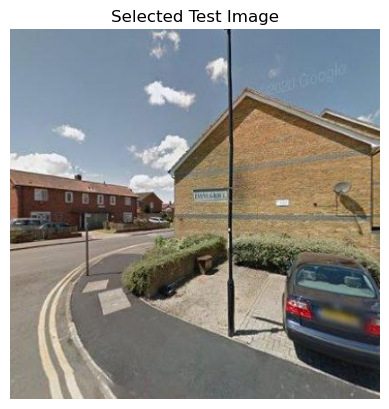

In [60]:
import cv2
from pytorch_grad_cam.utils.image import preprocess_image

# Load image
test_image = cv2.imread(test_image_path)[:, :, ::-1]  # Convert BGR to RGB

# Display the image
plt.imshow(test_image)
plt.axis("off")
plt.title("Selected Test Image")
plt.show()

In [67]:
# Set model to training mode for Grad-CAM
model.train()

# Enable gradient computation
input_tensor.requires_grad = True

# Preprocess image
input_tensor = preprocess_image(test_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

New https://pypi.org/project/ultralytics/8.3.49 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.7 🚀 Python-3.10.13 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 10827MiB)
engine/trainer: task=detect, mode=train, model=/gpfs/gibbs/project/miranda/fwb7/yolov8/beta3/v3_data_yolo11x2/weights/best.pt, data=/vast/palmer/scratch/miranda/fwb7/yolov8/v3/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fals

train: Scanning /vast/palmer/scratch/miranda/fwb7/yolov8/v3/train/labels.cache... 1110 images, 155 backgrounds, 0 corrupt: 100%|██████████| 1110/1110 [00:00<?, ?it/s]
val: Scanning /vast/palmer/scratch/miranda/fwb7/yolov8/v3/valid/labels.cache... 297 images, 39 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<?, ?it/s]


: 

: 

In [62]:
# Perform YOLO inference on the selected image
test_result = model(test_image_path)  # Run inference with YOLO
test_detection = results[0]  # Get detections for the image


image 1/1 /vast/palmer/scratch/miranda/fwb7/yolov8/v3/test/images/iSiweDBXsdemDscelgPrWg_270_jpg.rf.21dd8476c48c2b52fc4313fe606e47fa.jpg: 416x416 3 stationary-car-offstreets, 1 stationary-car-onstreet, 50.4ms
Speed: 22.4ms preprocess, 50.4ms inference, 6.1ms postprocess per image at shape (1, 3, 416, 416)


In [63]:
# Select the last convolutional layer of the YOLO model
target_layer = model.model.model[-2]  # Adjust this based on YOLO's architecture

In [65]:
from pytorch_grad_cam import GradCAM

# Initialize Grad-CAM
cam = GradCAM(model=model.model, target_layers=[target_layer])

In [66]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Generate Grad-CAM for a specific detection (e.g., the first detection)
class_id = int(detections.boxes.cls[0])  # Class ID of the first detected object
print(class_id)
# Wrap the class_id in ClassifierOutputTarget
targets = [ClassifierOutputTarget(class_id)]

# Generate the Grad-CAM heatmap
grayscale_cam = cam(input_tensor=input_tensor, targets=targets, eigen_smooth=True)

# Take the first image in the batch
grayscale_cam = grayscale_cam[0, :]

4


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:


# Overlay Grad-CAM heatmap on the image
visualization = show_cam_on_image(image / 255.0, grayscale_cam, use_rgb=True)

# Display the Grad-CAM result
plt.imshow(visualization)
plt.axis("off")
plt.title("Grad-CAM Heatmap")
plt.show()

In [ ]:

# Select the last convolutional layer of the YOLO model
target_layer = model.model.model[-2]  # Adjust this based on YOLO's architecture

# Initialize Grad-CAM
cam = GradCAM(model=model.model, target_layer=target_layer, use_cuda=torch.cuda.is_available())

# Generate Grad-CAM for a specific detection (e.g., the first detection)
class_id = int(detections.boxes.cls[0])  # Class ID of the first detected object
grayscale_cam = cam(input_tensor=input_tensor, targets=[class_id], eigen_smooth=True)

# Overlay Grad-CAM heatmap on the image
visualization = show_cam_on_image(image / 255.0, grayscale_cam, use_rgb=True)

# Display the Grad-CAM result
plt.imshow(visualization)
plt.axis("off")
plt.title("Grad-CAM Heatmap")
plt.show()

# HYPERPARAMETER FINETUNING for V3 YOLO11X Model


# Training a Cascade R-CNN Model Using Detectron2

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

ModuleNotFoundError: No module named 'detectron2'